<a href="https://colab.research.google.com/github/erjank/563-a1/blob/main/feb24/mc-lj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy
import matplotlib.pyplot as plt

def pbc(d,L):
  for i,x in enumerate(d):
    if x > L/2:
      d[i] = x-L
    elif x <= -L/2:
      d[i] = x+L
  return d

def distance(ri,rj,L):
  d = pbc(rj-ri,L)
  return numpy.linalg.norm(d)

def lj(r,epsilon=1.,sigma=1.):
  return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

class simulation():
  def __init__(self,N=100,L=10,T=1.,maxD=0.1,maxSteps=10,debug=False,seed=2):
    numpy.random.seed(seed)
    self.N = N
    self.L = L
    self.T = T
    self.maxD = maxD
    self.accept = 0
    self.reject = 0
    self.rcut = 2.5
    self.pos = numpy.zeros((N,3))
    self.debug = debug
    self.maxSteps = maxSteps
    self.energies = numpy.zeros(maxSteps)
    for i in range(self.N):
      while True:
        self.pos[i] = numpy.random.uniform(low=-L/2,high=L/2,size=3)
        if self.energy(i,initializing=True)<=0.:
          break
    self.E = self.energy()
    for i in range(self.maxSteps):
      self.trial()
      if self.debug:
        print("{:03}:   {:.2f}".format(i, self.E))
      self.energies[i] = self.E

  def energy(self,i=None,initializing=False):
    E = 0
    if i is not None and initializing:
      pi = self.pos[i]
      for j in range(i):
        r = distance(pi,self.pos[j],self.L)
        if r <= self.rcut:
          E += lj(r)
      return E
    if i is None:
      for i in range(self.N-1):
        pi = self.pos[i]
        for j in range(i+1,self.N):
          r = distance(pi,self.pos[j],self.L) # speed up with numpy
          if r <= self.rcut:
            E += lj(r)
      return E

  def trial(self):
    i = numpy.random.randint(self.N)
    oldP = numpy.copy(self.pos[i])
    oldE = self.E
    oldEi = self.energy()
    d = numpy.random.uniform(low=-self.maxD,high=self.maxD,size=3)
    newP = pbc(oldP+d,self.L)
    self.pos[i] = newP
    newEi = self.energy()
    dE = newEi - oldEi
    if numpy.random.uniform() <= numpy.exp(-dE/self.T):
      if self.debug:
        print("accept")
      self.accept += 1
      self.E += dE
      return
    else:
      if self.debug:
        print("reject")
      self.pos[i] = oldP
      self.reject += 1
      self.E = oldE
      return

In [23]:
def autocorr1D(array):
  ft = numpy.fft.rfft(array - numpy.average(array))
  acorr = numpy.fft.irfft(ft * numpy.conjugate(ft)) / (len(array) * numpy.var(array))
  dt = numpy.where(acorr<0)[0][0]
  nsamples = len(array)//dt
  acorr = acorr[dt:nsamples]
  #return acorr[0 : len(acorr) // 2]
  return nsamples, dt


In [4]:
density = 0.5
N = 32
V = N/density
L = V**(1/3)
print(L)
maxSteps = 10000
s = simulation(N=N, L=L, maxSteps = maxSteps,debug=False,seed=23)
print("{:02f} +/- {:02f}".format(s.energies.mean()/N, s.energies.std()/N))

3.9999999999999996
-3.070694 +/- 0.131550


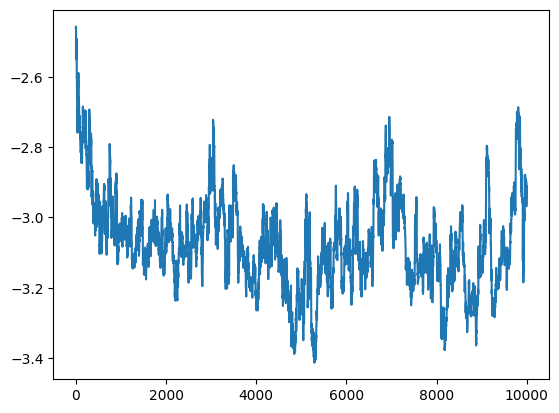

In [26]:
plt.plot(s.energies[0:]/N)
plt.show()

In [22]:
for start in range(0,10000,100):
  print(start, autocorr1D(s.energies[start:]))


0 11
100 11
200 11
300 11
400 11
500 11
600 11
700 11
800 10
900 11
1000 11
1100 10
1200 10
1300 10
1400 10
1500 10
1600 10
1700 10
1800 9
1900 9
2000 9
2100 9
2200 8
2300 8
2400 8
2500 8
2600 8
2700 8
2800 8
2900 8
3000 8
3100 8
3200 8
3300 8
3400 13
3500 13
3600 14
3700 14
3800 7
3900 7
4000 7
4100 7
4200 8
4300 11
4400 12
4500 13
4600 14
4700 15
4800 11
4900 12
5000 13
5100 15
5200 18
5300 12
5400 12
5500 11
5600 9
5700 10
5800 10
5900 10
6000 9
6100 10
6200 10
6300 9
6400 4
6500 4
6600 4
6700 4
6800 4
6900 4
7000 3
7100 7
7200 10
7300 12
7400 12
7500 10
7600 11
7700 10
7800 10
7900 9
8000 10
8100 10
8200 9
8300 8
8400 7
8500 6
8600 7
8700 7
8800 8
8900 7
9000 5
9100 3
9200 4
9300 4
9400 4
9500 4
9600 3
9700 4
9800 3
9900 4


In [25]:
real_average = s.energies[4700::342].mean()/N
real_std = s.energies[4700::342].std()/N
print(real_average, real_std)

-3.112697342955454 0.13976771052807296


In [24]:
ns,dt = autocorr1D(s.energies[4700:])
print(ns,dt)

15 342


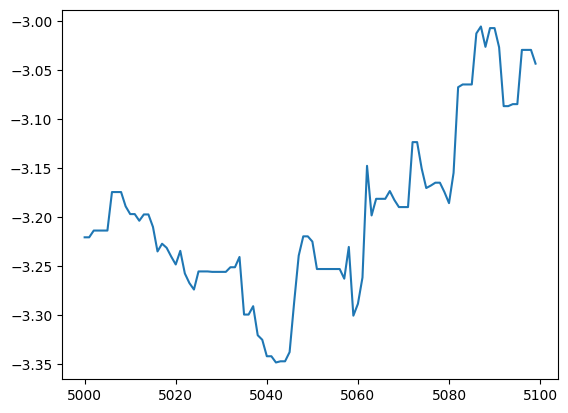

N=32, AverageE: -3.09


In [7]:
start = 5000
steps = 100
plt.plot(range(start,start+steps),s.energies[start:start+steps]/N)
plt.show()
print("N={}, AverageE: {:.2f}".format(N,s.energies[maxSteps//2:].mean()/N))
# per particle around -4.25 with  N=32, density .7, L=3.57, 10k maxSteps
# per particle around -3.91 with  N=20, density .7, L=3.057, 10k maxSteps
# per particle around  with  N=28, density .7, L=3.057, 10k maxSteps


In [ ]:
for N in range(20,51,5):
  density = 0.5
  V = N/density
  L = V**(1/3)
  maxSteps = 10000
  s = simulation(N=N, L=L, maxSteps = maxSteps,debug=False)
  print("N={}, AverageE: {:.2f}".format(N,s.energies[maxSteps//2:].mean()/N))

N=20, AverageE: -2.98
N=25, AverageE: -3.12
N=30, AverageE: -3.10
N=35, AverageE: -3.08
N=40, AverageE: -3.22
N=45, AverageE: -3.15
N=50, AverageE: -3.26


In [ ]:
import time
for N in range(20,51,5):
    density = 0.7
    V = N/density
    L = V**(1/3)
    maxSteps = 10000
    t1 = time.perf_counter()
    s = simulation(N=N, L=L, maxSteps = maxSteps,debug=False)
    t2 = time.perf_counter()
    print("\nN=",N,"; {:.2f} seconds/sim".format(t2-t1))
    print("N={}, AverageE: {:.2f}".format(N,s.energies[maxSteps//2:].mean()/N))

N=20, AverageE: -3.91
N=25, AverageE: -4.13
N=30, AverageE: -4.22
N=35, AverageE: -4.35
N=40, AverageE: -4.35
N=45, AverageE: -4.47
N=50, AverageE: -4.39
